# INCOMPLETE !!!

In [35]:
import albumentations as A # to make holes 
from torchvision.transforms import v2 # for other transforms 

import torch 
import torch.nn as nn 
import torch.nn.functional as F 

from PIL import Image 
import numpy as np 

seed = 10 
torch.manual_seed(seed) 
torch.cuda.manual_seed(seed) 
torch.cuda.manual_seed_all(seed) 

In [36]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [37]:
cut_tfm = A.CoarseDropout(num_holes_range=(1,3), p=1)
tv_tfms = v2.Compose([
    v2.ToImage(), 
    v2.ToDtype(torch.float32, scale=True), 
    v2.RandomHorizontalFlip(p=0.5), 
    v2.RandomAffine(degrees=(-10, 10), scale=(0.9, 1.1))
])



In [38]:
from torchvision.datasets import MNIST 

train_ds = MNIST('./data/', train=True, download=True)#|, target_transform=tv_tfms)

def train_preprocess(pil_img, device=device): 
    img = cut_tfm(image=np.array(pil_img))['image']
    return tv_tfms(img).to(device) 



conv, then deconv 

In [39]:
class ImageVAE_enc(nn.Module): 
    def __init__(self, d=32, hidden_layer_size=100):
        super(ImageVAE_enc, self).__init__()

        # conv (1 input channel) to a small layer inside 
        # 28x28 (MNIST dataset)
        self.conv1 = nn.Conv2d(1, d, 4, 2, 3, dtype=torch.float32) # 16x16 
        self.conv2 = nn.Conv2d(d, d*2, 4, 2, 1, dtype=torch.float32) # 8x8 
        self.conv2_bn = nn.BatchNorm2d(d*2)
        self.conv3 = nn.Conv2d(d*2, d*4, 4, 2, 1, dtype=torch.float32) # 4x4 
        self.conv3_bn = nn.BatchNorm2d(d*4)
        self.conv4 = nn.Conv2d(d*4, hidden_layer_size, 4, 1, 0, dtype=torch.float32) # 1x1 


    def forward(self, input):
        x = F.leaky_relu(self.conv1(input), 0.2)
        x = F.leaky_relu(self.conv2_bn(self.conv2(x)), 0.2)
        x = F.leaky_relu(self.conv3_bn(self.conv3(x)), 0.2)
        x = torch.sigmoid(self.conv4(x))

        return x
        

class ImageVAE_dec(nn.Module):
    def __init__(self, d=32, hidden_layer_size=100):
        super(ImageVAE_dec, self).__init__()

        # deconv back to normal image size 
        # starts as 1x1 img with hidden_layer_size channels 
        self.deconv1 = nn.ConvTranspose2d(hidden_layer_size, d*4, 4, 1, 0, dtype=torch.float32) # 4x4 
        self.deconv1_bn = nn.BatchNorm2d(d*4)
        self.deconv2 = nn.ConvTranspose2d(d*4, d*2, 4, 2, 1, dtype=torch.float32) # 8x8 
        self.deconv2_bn = nn.BatchNorm2d(d*2)
        self.deconv3 = nn.ConvTranspose2d(d*2, d, 4, 2, 1, dtype=torch.float32) # 16x16 
        self.deconv3_bn = nn.BatchNorm2d(d)
        self.deconv4 = nn.ConvTranspose2d(d, 1, 4, 2, 3, dtype=torch.float32) # 28x28 

        # NOTE: in deconv, the kernel size is important, https://distill.pub/2016/deconv-checkerboard/ 
        

    def forward(self, input):
        x = F.relu(self.deconv1_bn(self.deconv1(input)))
        x = F.relu(self.deconv2_bn(self.deconv2(x)))
        x = F.relu(self.deconv3_bn(self.deconv3(x)))
        x = torch.tanh(self.deconv4(x))

        return x
    


In [40]:
enc = ImageVAE_enc().to(device) 
dec = ImageVAE_dec().to(device) 


# training loop 
epoch = 1 
batch_size = 25
loss_fn = nn.MSELoss() 
optimizer = torch.optim.Adam(list(enc.parameters()) + list(dec.parameters()), lr=1e-4) 

prev_avg_loss = 10000000 
all_avg_losses = [] 
while True: 
    epoch_losses = [] 
    for b in range(0, len(train_ds), batch_size): 
        imgs = torch.stack([train_preprocess(train_ds[b+i][0]) for i in range(batch_size)]) 
        
        emb = enc(imgs) 
        rec = dec(emb) 
        # compare reconstruction loss 
        loss = loss_fn(imgs, rec) 
        
        epoch_losses.append(loss.item()) 

        loss.backward() 
        optimizer.step() 
        optimizer.zero_grad() 

    epoch_avg_loss = sum(epoch_losses)/len(epoch_losses) 
    print("EPOCH {} AVG LOSS: {}".format(epoch, epoch_avg_loss))

    all_avg_losses.append(epoch_avg_loss) 
    if epoch_avg_loss > 1.05*prev_avg_loss: 
        # assume it's converged already so cut 
        break 

    prev_avg_loss = epoch_avg_loss 

    epoch += 1 



EPOCH 1 AVG LOSS: 0.03297532988324141
EPOCH 2 AVG LOSS: 0.01519503361894749
EPOCH 3 AVG LOSS: 0.012010115133986497
EPOCH 4 AVG LOSS: 0.010257595896449251
EPOCH 5 AVG LOSS: 0.009177748407819309
EPOCH 6 AVG LOSS: 0.008362487262347713
EPOCH 7 AVG LOSS: 0.007692978772101924
EPOCH 8 AVG LOSS: 0.007118518411492308
EPOCH 9 AVG LOSS: 0.006604070398413266
EPOCH 10 AVG LOSS: 0.00616752063195842
EPOCH 11 AVG LOSS: 0.005733321750109705
EPOCH 12 AVG LOSS: 0.0053969531133770945
EPOCH 13 AVG LOSS: 0.005078430098947138
EPOCH 14 AVG LOSS: 0.004824952972315563
EPOCH 15 AVG LOSS: 0.004622973245762599
EPOCH 16 AVG LOSS: 0.004462733311908475
EPOCH 17 AVG LOSS: 0.004310920253434839
EPOCH 18 AVG LOSS: 0.004198796372123373
EPOCH 19 AVG LOSS: 0.004096525038864153
EPOCH 20 AVG LOSS: 0.004007089216708361
EPOCH 21 AVG LOSS: 0.003925758670084179
EPOCH 22 AVG LOSS: 0.003854240662282488
EPOCH 23 AVG LOSS: 0.0037942456325011638
EPOCH 24 AVG LOSS: 0.0037475574771330383
EPOCH 25 AVG LOSS: 0.003689683321087311
EPOCH 26 

KeyboardInterrupt: 

In [43]:
# i can't be bothered to wati for it to finish running so i just truncated it yea 
torch.save(enc, './ignore/enc_epoch36.pt')
torch.save(dec, './ignore/dec_epoch36.pt')

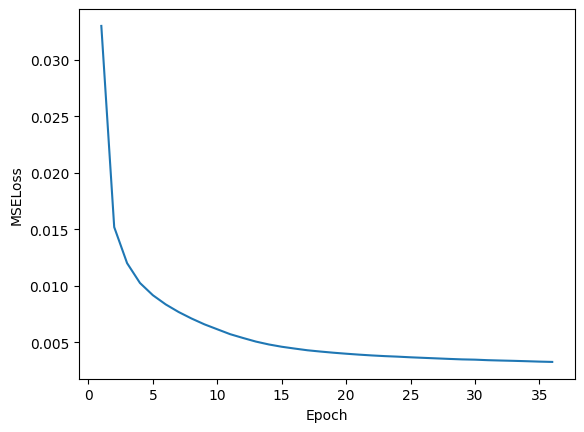

In [44]:
import matplotlib.pyplot as plt 

plt.plot(list(range(1, 1+len(all_avg_losses))), all_avg_losses) 
plt.xlabel('Epoch') 
plt.ylabel("MSELoss") 

plt.show() 

that looks like a good training curve 

from here on, you can actually train a classifier the 
you have 
emb = enc(img).squeeze() 

and that'll give you a tensor of (batch_size, hidden_layer_size), where each (hidden_layer_size) vector contains enough information to describe the entire image. 
this can make the image classifer need to learn less --> good 